<h1>Image pre-processing for object-detection model</h1>
<p style="color:blue;font-size:18px;">Step 1: Read imges</p>

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random

In [13]:
# Defining global variable path that contains train / train_resized folders
image_folder = "/Users/peisch/code/WebScraper/Images"

# Function to load folder into arrays and then it returns that same array
def loadImages(path):
    image_files = sorted([os.path.join(path, 'train', file)
         for file in os.listdir(path + "/train") if file.endswith('.jpg')])
    return image_files

In [14]:
# Check number of images in training set
len(loadImages(image_folder))

3919

<p style="color:blue;font-size:18px;">Step 2: Resize images</p>

In [15]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [16]:
# Resize images into dimension determined and save resized images in new folder
# Generate a csv file including image information ie. origin weight/height, new width/height
# BE CAREFUL: we use "image_folder" global variable defined at the beginnning of the notebook

def resizing(data):
    
    # in the path given, create a folder for upcoming resized images if not existing
    os.chdir(image_folder)
    try:
        os.makedirs('train_resized')
        print("Resizing processing ... ")
    except FileExistsError:
        print("Directory 'train_resized' already exists. Resizing processing ... ")
        
    # Loop: for each image in the folder, store the 1/image, 2/origin size, 3/filename as imageId
    
    # create a dataframe to store information with determined typing for each column
    dtypes = np.dtype([
          ('imageId', str),
          ('origin_width', int),
          ('origin_height', int),
          ('new_width', int),
          ('new_height', int),
          ])
    empty_data = np.empty(0, dtype=dtypes)
    df = pd.DataFrame(empty_data)
    img_list = []
    
    # set working directory (folder) to store processed images
    working_dir = image_folder + "/train_resized/"
    os.chdir(working_dir)
        
    # setting dimemsion of the resized image and update count for processed images
    # be careful: for YoloV3 Darknet, image dimension has to be multiplication of 32 !!!
    count:int = 0
    height:int = 416
    width:int = 416
    dim = (width, height) # dimension is a tuple
    res_img = []
    
    # for each absolute path in the list 'data':
    # 1/read image; 2/get its origin image and imageID; 3/update image list;
    # 4/store info in dataframe; 5/store resized image in created "train_resized" folder
    
    for imgStr in data:
        img = [cv2.imread(imgStr, cv2.IMREAD_UNCHANGED)]
        origin_size = img[0].shape # shape of each image is a tuple of (height, weight, channel)
        origin_width = origin_size[1]
        origin_height = origin_size[0]
        imageId = imgStr.rstrip('.jpg').replace(f"{image_folder}/train/", "")
        img_list[len(img_list):] = [imageId] # equiv to "append" to a list
        
        # store info as a new row in the dataframe created above
        col_names = ['imageId', 'origin_width', 'origin_height', 'new_width', 'new_height']
        new_row = pd.DataFrame([[str(imageId), origin_width, origin_height, width, height]], columns = col_names)
        df = df.append(new_row)
        
        # resize image and store as .jpg in created folder
        res = cv2.resize(img[0], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)
        count = count + 1
        filename:str = imageId + ".jpg"
        cv2.imwrite(filename, res)
    
    # Checking the size after processing
    print(f"Resized image dimension : {res_img[-1].shape}. Example as follows:")
    
    # Visualizing one of the images in the array
    example_image = res_img[-1]
    display_one(example_image)
    
    # Delete duplicates of the df
    # Save dataframe into a CSV file (write or override .csv file)
    df = df.drop_duplicates()
    df.to_csv('imageTable.csv', index = False)
            
    print(f"Resizing finished. \n [ {count} ] image(s) resized and saved in directory: {working_dir} ")  
    return img_list

<p style="color:blue;font-size:18px;">Step 3: Recalculate image annotations</p>

In [17]:
def get_label(images):
    # set working dir to the resized folder 
    working_dir = image_folder + '/train_resized'
    os.chdir(working_dir)
    # load csv file containing image information
    df_img = pd.read_csv('imageTable.csv')
    df_img = df_img.set_index('imageId')
    
    dtypes = np.dtype([
          ('class', str),
          ('origin_xmin', int),
          ('origin_ymin', int),
          ('origin_xmax', int),
          ('origin_ymax', int),
          ('imageId', str)
          ])
    #empty_data = np.empty(0, dtype=dtypes)
    #df = pd.DataFrame(empty_data)
    
    image_buffer:str = ""
    
    for img in images:
        os.chdir(image_folder + '/train/Label')
        image_buffer = img
        filename = img + '.txt'
        # open origin .txt file and get information 
        try: 
            f = open(filename,"r")
            content = f.read()   
            # parse content and store in info list
            annotations = content.lstrip().rstrip().split('\n')
            annot_str:str = ""

            # each_annot is a string with shape: 'Dress', '483.84', '228.734651', '691.2', '683.0'
            for each_annot in annotations:
                # load info about the origin image stored in csv file
                line = df_img.loc[img]
                o_w = line['origin_width']
                o_h = line['origin_height']
                n_w = line['new_width']
                n_h = line['new_height']
                each_annot = each_annot.replace(",\n", ", ")
                # replace "Dress" by its class number (zero)
                each_annot = each_annot.replace("Dress", "0")
                # now access to information contained by dress and redo the annotation for Yolo3 model
                # annotation for Yolo3: x(centre), y(center), width, height (with all in range [0, 1])
                dress:list = each_annot.split(" ") #list
                xmin = dress[1]
                ymin = dress[2]
                xmax = dress[3]
                ymax = dress[4]
                # X_CENTER_NORM = X_CENTER_ABS/IMAGE_WIDTH
                # Y_CENTER_NORM = Y_CENTER_ABS/IMAGE_HEIGHT
                # WIDTH_NORM = WIDTH_OF_LABEL_ABS/IMAGE_WIDTH
                # HEIGHT_NORM = HEIGHT_OF_LABEL_ABS/IMAGE_HEIGHT
                x = (float(xmin) + float(xmax))/2/o_w
                y = (float(ymin) + float(ymax))/2/o_h
                box_w = (float(xmax)-float(xmin))/o_w
                box_h = (float(ymax)-float(ymin))/o_h
                # the string has the right form for yolo annotation
                each_box:str = f"0 {x} {y} {box_w} {box_h}"
                annot_str:str = each_box + "\n" + annot_str
            annot_str = annot_str.rstrip()
            f.close
        
        
            # create a folder to store .txt files named 'new_labels'
            os.chdir(image_folder)
            try: os.mkdir('train_resized') 
            except: FileExistsError
            os.chdir(image_folder + '/train_resized')    
            new_file = open(filename,"w")
            n = new_file.write(annot_str)
            new_file.close()
            
        except: FileNotFoundError
        
    print(f"New annotation .txt files had been saved in directory: {image_folder}/train_resized ")

<p style="color:blue;font-size:18px;">Step 4: Create train and test path files</p>

In [18]:
# this function is to produce train.txt and test.txt files used in Yolo3 training
def create_txt_file(img_list):
    # full path list
    store_list = []
    for i in range(len(img_list)): 
        img_path = f"data/obj/{img_list[i]}.jpg"
        store_list.append(img_path)
    
    # randomise train set and test set
    img_nb = len(store_list)
    # parameter of the dataset separation ratio
    train_r = 0.8
    test_r = 0.2
    train_nb = round(img_nb * train_r)
    test_nb = img_nb - train_nb
    
    train_index = random.sample(range(img_nb), k = train_nb)
    # train path list
    train_list = []
    for i in train_index : 
        path = store_list[i]
        train_list.append(path)
    # test path list
    test_list = list(set(store_list) - set(train_list))
    print(f"Set separation done. Train set size: {len(train_list)}. Test set size: {len(test_list)}.")
    
    # save those lists into .txt files
    # create a folder to store .txt files named 'train_test_file'
    os.chdir(image_folder)
    try: os.mkdir('train_test_path') 
    except: FileExistsError
    os.chdir(image_folder + '/train_test_path')
    
    # create and save train.txt
    train_str = '\n'.join(train_list)
    file1 = open("train.txt", "w")
    n = file1.write(train_str)
    file1.close()
    print(f"train.txt file had been saved in directory: {image_folder}/train_test_path")
    
     # create and save test.txt
    test_str = '\n'.join(test_list)
    file2 = open("test.txt", "w")
    n = file2.write(test_str)
    file2.close()
    print(f"test.txt file had been saved in directory: {image_folder}/train_test_path")
    
    return store_list

<p style="color:blue;font-size:18px;">Execute sequential functions</p>

Resizing processing ... 
Resized image dimension : (416, 416, 3). Example as follows:


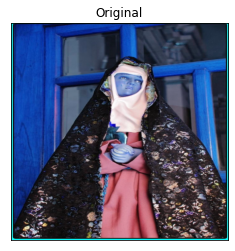

Resizing finished. 
 [ 3919 ] image(s) resized and saved in directory: /Users/peisch/code/WebScraper/Images/train_resized/ 
New annotation .txt files had been saved in directory: /Users/peisch/code/WebScraper/Images/train_resized 
Set separation done. Train set size: 3135. Test set size: 784.
train.txt file had been saved in directory: /Users/peisch/code/WebScraper/Images/train_test_path
test.txt file had been saved in directory: /Users/peisch/code/WebScraper/Images/train_test_path


['data/obj/afa107859b43fc91.jpg',
 'data/obj/afa29933c21ee89b.jpg',
 'data/obj/afaa0f06e2f449f3.jpg',
 'data/obj/afac3d623a2d7de8.jpg',
 'data/obj/afac612675290fc6.jpg',
 'data/obj/afae8c2c166b462c.jpg',
 'data/obj/afaffb6744658bb5.jpg',
 'data/obj/afb3c85a97ed8954.jpg',
 'data/obj/afba1f487fa3de1d.jpg',
 'data/obj/afbc680d9fc03a2c.jpg',
 'data/obj/afbd7c1a2ed6dbd1.jpg',
 'data/obj/afbebed552e360c6.jpg',
 'data/obj/afbf2aad922ca74b.jpg',
 'data/obj/afc100c08e9b027e.jpg',
 'data/obj/afc1bbbd340a43fb.jpg',
 'data/obj/afc2790141de359b.jpg',
 'data/obj/afc3270d3e5a590a.jpg',
 'data/obj/afc7ad118422043d.jpg',
 'data/obj/afca9cbb449421a8.jpg',
 'data/obj/afcd3ff79713b815.jpg',
 'data/obj/afd263b254a13685.jpg',
 'data/obj/afd2abf3775106af.jpg',
 'data/obj/afd5724f192e5155.jpg',
 'data/obj/afd67b76c22d839a.jpg',
 'data/obj/afd88c996f294a58.jpg',
 'data/obj/afdb4c497251c746.jpg',
 'data/obj/afdb5698a987b5d3.jpg',
 'data/obj/afdb69fc77ad5009.jpg',
 'data/obj/afdbc0703cd52c39.jpg',
 'data/obj/afd

In [19]:
# Load data with given image folder path
dataset = loadImages(image_folder)

# Call the resizing function over data and save imageTable.csv
images = resizing(dataset)

# Process all label .txt files and save new .txt files in new_labels folder
get_label(images)

# Create path file for Yolo3 training
create_txt_file(images)